# Business Objective
We want to develop a recommendation system catered to the needs of the users, while still being profitable for our business. In our minds, this goal of catering to our users, though not exactly the same, is very highly correlated with the goal of being a profitable business. If we provide better recommendations, more users will want to come to our website to consume more content. Further, existing users will continue to use our website for their recommendations. If we simply recommend the most popular movies, there will be no novelty or personalization, and users would not have any reason to choose our website over another. Thus, it is important that we make highly accurate and personalized recommendations keeping just the right amount of novelty to serve new content.

The metrics that we care about to ensure higher engagement with the content would be both the coverage, to ensure that we are not just recommending the most popular movies, as well as the test error, which is the similarity between the rank given by our user after watching a recommended movie vs what we predicted. 

In [1]:
# Importing Libraries
import os
%matplotlib inline

import gc
gc.collect()


import warnings
warnings.simplefilter('ignore')

# Loading custom built functions
from model.nearest_neighbor_model import KNN
from model.lightfm_model import lightfm_model
from model.baseline_model import baseline_bias_model
from model.als_model import get_best_rank, cross_validation, plot_performance_als, get_best_sample_size
from utils.data_loader import load_spark_df, load_pandas_df, spark_to_sparse
from utils.sample_df import random_sample, sample_df_threshold, sample_popular_df, sample_df_threshold_use_pandas

from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import ParamGridBuilder
from surprise.prediction_algorithms.knns import KNNWithZScore

## 1. Loading Data 

We implement a function to cache and load the dataframe from secondary memory to reduce data load time

In [2]:
# Setting Directory path
base_path = os.getcwd()
dir_name = 'ml-20m'
CACHE_DIR = base_path + '/cache/'
DATA_DIR =  base_path + '/data/'

# Loading the Data Frames
ratings_pandas_df = load_pandas_df(dir_name=dir_name, 
                                 file_name='ratings', 
                                 use_cache=True,
                                 DATA_DIR=DATA_DIR,
                                 CACHE_DIR=CACHE_DIR)

print('\nSampling DataFrame ...')
ratings_spark_df = sample_df_threshold_use_pandas(ratings_pandas_df, 
                                                  n=10**5, 
                                                  min_user_threshold=5, 
                                                  min_item_threshold=5,
                                                  quite=False
                                                 )

Loading from /media/anirudh/Data/Code/Fall 2019/Personalization/project/personalization_1/cache/ml-20m_ratings.msgpack

Sampling DataFrame ...
Length before sampling: 20000263
Length after thresholding: 19912386
Length after sampling: 100000


There are a number of ways we could sample our data. In particular, we implemented and tested 3 sampling methods:

The first is raw random sampling, where we simply select a random sample of our data. It is a simple samplin g method, however, we found that it doesn't work well in practice, as we have no thresholding criteria - So by selecting random rows, we are not fine tuning the kind of users, or movies (popular or unpopuolar) we want to sample. Had the users and movies been uniformaly distributed, this would have been okay. But, we see that in our data set, the kinds of users and movies show a lot of hetrogenity, with the number of movies rated by each user, as well as the number of times each movie was rated, varying a lot across users. Therefore, we moved on to more sophisticated sampling technique

In the second sampling technique, we first selected a subset of the data based on a threshold. So we initially removed any user who had rated less than 'x' items, as well as any movie which had been rated less than 'y' times. We set x and y to 5. After getting the initial thresholded dataset, we then randomly sampled a 100000 rows. 

In the third technique, we first selected the rows with the top 'a' users, and the rows with the top 'b' movies. After getting those 2 datasets, we performed an inner merge to include only users which are in the top 'a', and movies which are in the top 'b'. From this merged dataset containing the most popular users and movies, we then sampled a fraction of the rows for our final sampled dataset.

Having tried all these sampling methods (detailed code in utils/sample.py), we selected method 2 as our final sampling technique. This was because choosing all users/movies abive a certain threshold was more in line with our final objective of building a recommendation system which caters to the needs of everyone, not just users who rate a lot of movies.

## 2. Analysis of methods

### 2.1 Baseline Method: Bias based model

We first fit a bias only model to the data to set a benchmark for baseline model. 

In [3]:
%%time

baseline_bias_model(ratings_spark_df)

Evaluating RMSE, MAE of algorithm BaselineOnly on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9656  0.9674  0.9476  0.9544  0.9622  0.9594  0.0074  
MAE (testset)     0.7506  0.7532  0.7369  0.7467  0.7517  0.7478  0.0059  
Fit time          0.14    0.14    0.14    0.17    0.14    0.14    0.01    
Test time         0.11    0.12    0.10    0.12    0.12    0.11    0.01    


CPU times: user 9.75 s, sys: 170 ms, total: 9.92 s
Wall time: 12.3 s


### 2.2 Model based method using Alternating Least Squares method

We build a Matrix Factorization model using ALS method, and iterate over different rank ranges to find the optimal rank

#### 2.2.1 Finding best hyperparameter setting using cross validation

In [4]:
%%time
gc.collect()

# Creating a Parameter Grid for ALS
model = ALS(userCol="userId",
                  itemCol="movieId",
                  ratingCol="rating",
                  coldStartStrategy="drop",
                  nonnegative=True)

paramGrid = ParamGridBuilder() \
            .addGrid(model.maxIter, [3]) \
            .addGrid(model.regParam, [0.01,0.1]) \
            .addGrid(model.rank, [64, 128]) \
            .build()

# Finding best parameter combination from cross validation
best_hyper_parameter, best_model = cross_validation(ratings_spark_df, 
                                                     model=model, 
                                                     evaluator='Regression', 
                                                     param_grid=paramGrid, 
                                                     k_folds=3)

print("Best Hyper-parameter combination for ALS Model:")
display(best_hyper_parameter)
print('\n')

RMSE of Best Model on Test Set: 1.6046
Best Hyper-parameter combination for ALS Model:


,HyperParameter,Value
0,maxIter,3
1,regParam,0.1
2,rank,64




CPU times: user 862 ms, sys: 324 ms, total: 1.19 s
Wall time: 2min 24s


#### 2.2.2 For different ranks, plotting RMSE and coverage on training and test set

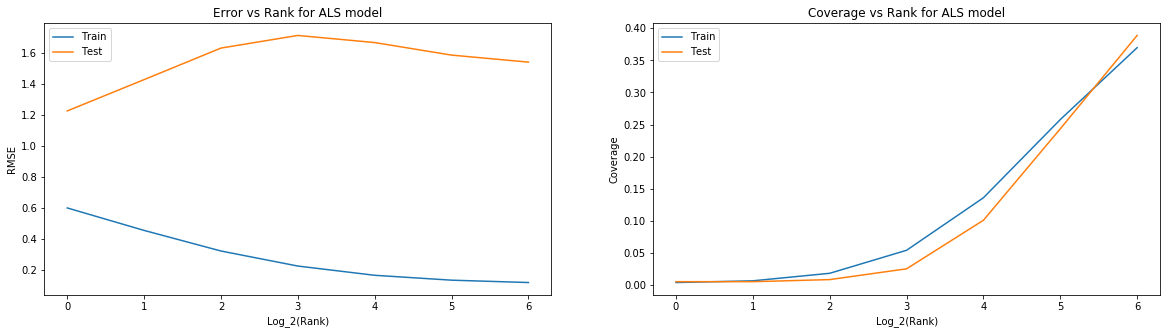

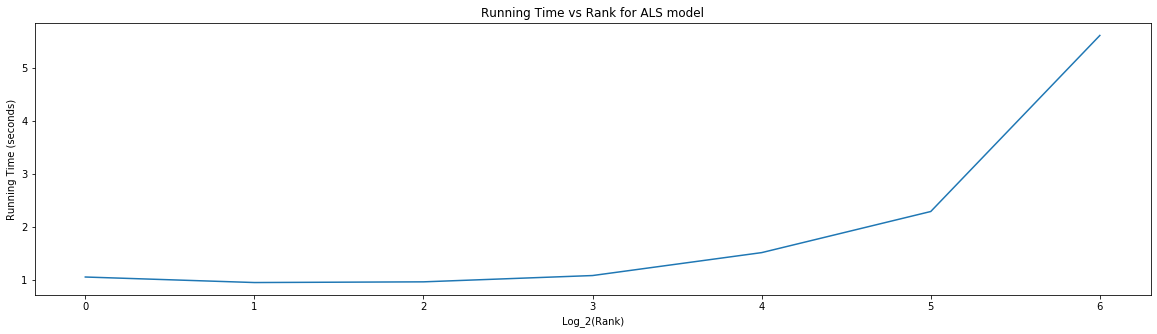

,Rank,RMSE_train,RMSE_test,Coverage_train,Coverage_test,Running_time
0,1.0,0.602109,1.228222,0.003662,0.005009,1.047310
1,2.0,0.457050,1.430165,0.006347,0.005009,0.943024
2,4.0,0.324214,1.633697,0.018064,0.008250,0.956176
3,8.0,0.227140,1.715166,0.053948,0.025044,1.075086
4,16.0,0.167508,1.669275,0.135848,0.100766,1.507782
5,32.0,0.136016,1.588325,0.257781,0.243371,2.283834
6,64.0,0.120750,1.543040,0.369828,0.388922,5.606803




CPU times: user 1.9 s, sys: 480 ms, total: 2.38 s
Wall time: 2min 5s


In [5]:
%%time
gc.collect()

pow_two_max_rank = 6

ranks = [2**i for i in range(pow_two_max_rank+1)]

report_df = get_best_rank(ratings_spark_df, ranks=ranks)

plot_performance_als(report_df)
display(report_df)
print('\n')

We observe the following:
1. The training error keeps on decreasing with increased rank, but the test error shows no significant improvement indicating signs of overfitting
2. The coverage of items improves with respect to rank
3. The time to fit the model takes expontially higher time in correlation with rank

Note: We use Catalog Coverage to take into account the number of unique movies that were recommended to atleast one user as a top choice amongst the set of all unique movies.

#### 2.2.3 For different sizes, plotting RMSE and coverage on training and test set

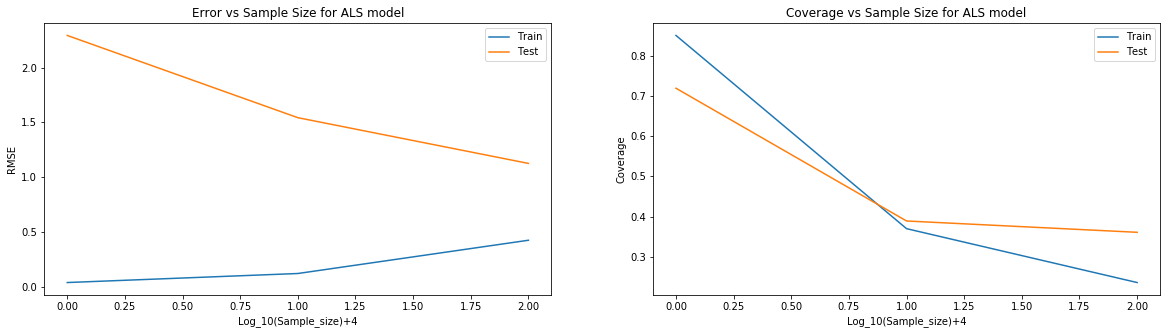

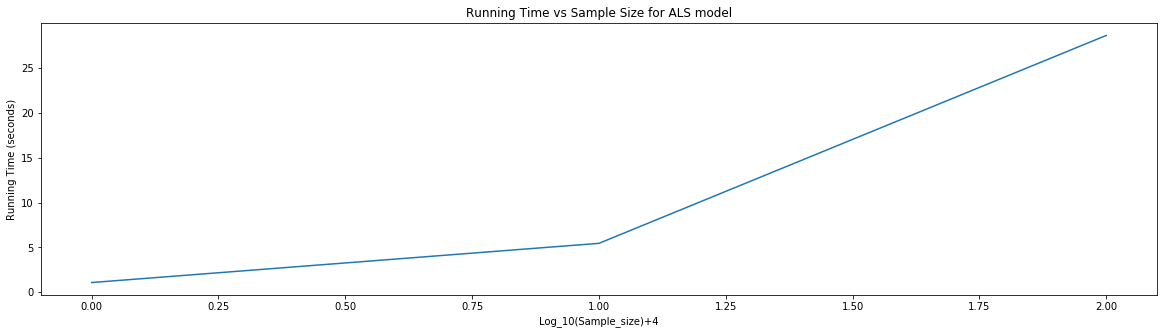

,Sample_size,RMSE_train,RMSE_test,Coverage_train,Coverage_test,Running_time
0,10000.0,0.038304,2.293550,0.850511,0.719187,1.090301
1,100000.0,0.120750,1.543040,0.369828,0.388922,5.456394
2,1000000.0,0.424297,1.125596,0.235813,0.360789,28.615721




CPU times: user 31.4 s, sys: 740 ms, total: 32.1 s
Wall time: 2min 33s


In [6]:
%%time
gc.collect()

sample_size = [10**i for i in range(4,7)]

report_df = get_best_sample_size(ratings_pandas_df, 
                                 sample_size = sample_size)

plot_performance_als(report_df, report_type='sample')
display(report_df)
print('\n')

### 2.3 LightFM:

We use LightFM model to find how it performs over over dataset. Due to memory constraints we use a smaller version of the movie lens dataset.

Loading from /media/anirudh/Data/Code/Fall 2019/Personalization/project/personalization_1/cache/ml-latest-small_ratings.msgpack
Performance of LightFm Model 

Precision 	 Train: 0.44 	 Test: 0.18
AUC 		 Train: 0.92 	 Test: 0.87


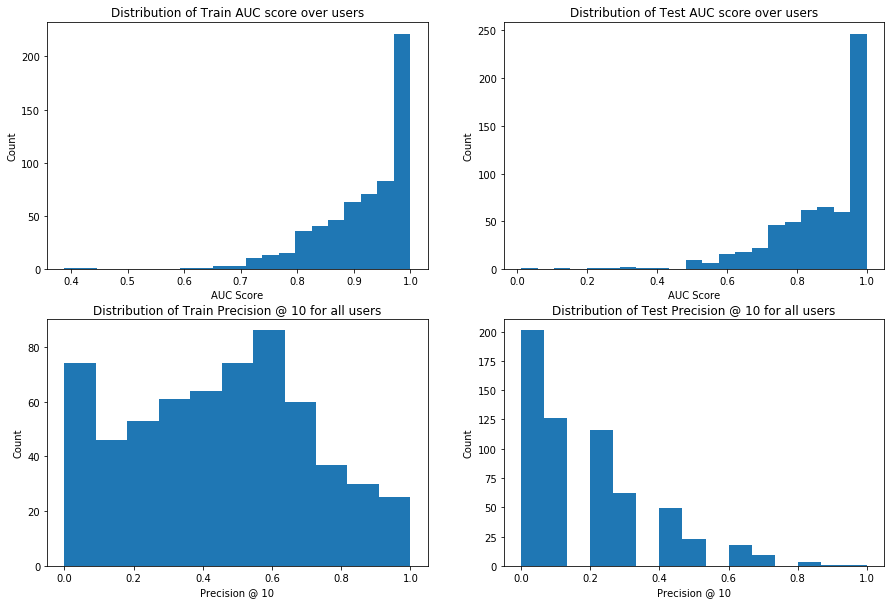



CPU times: user 56.9 s, sys: 81.5 ms, total: 57 s
Wall time: 55.9 s


In [7]:
%%time
gc.collect()

dir_name = 'ml-latest-small'
small_spark_df = load_spark_df(dir_name=dir_name, 
                                 file_name='ratings', 
                                 use_cache=True,
                                 DATA_DIR=DATA_DIR,
                                 CACHE_DIR=CACHE_DIR)

sparse_mat = spark_to_sparse(small_spark_df)
lightfm_model(sparse_mat, prec_at_k=10, train_split=0.8)

### 2.4. Neighborhood based method using Nearest Neighbor

We use Nearest Neighbor algorithm with z-score normalization of each user

In [8]:
%%time
gc.collect()

# Defining parameters for Nearest Neighbor model
sim_options = {'name': 'cosine',
               'user_based': True
               }
model = KNNWithZScore(sim_options=sim_options)

KNN(model=model, df=small_spark_df)

Evaluating RMSE, MAE of algorithm KNNWithZScore on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8995  0.9026  0.8974  0.8976  0.9011  0.8996  0.0020  
MAE (testset)     0.6839  0.6853  0.6819  0.6804  0.6841  0.6831  0.0017  
Fit time          0.29    0.32    0.29    0.27    0.27    0.29    0.02    
Test time         1.40    1.35    1.45    1.37    1.27    1.37    0.06    


CPU times: user 6.82 s, sys: 160 ms, total: 6.98 s
Wall time: 8.9 s


We observe that the Baseline Bias model performs quite well, and other more sophesiticated models (except lightFM) don't yield significant improvments over it hence the Bias model might be the most suited for production

We observe that LightFm model has high AUC, meaning it is producing quantifiably quality results.

# Conclusions

Our recommendation system is doing a fairly good job in terms of our metrics - low RMSE, fairly high coverage. There is still room for improvement, though. While this is a good starting point, we still need to run more tests before this is production ready. Apart from the metrics already in our notebook, which we could have calculated based on the dataset, we can calculate a few more metrics in a real world scenario:

1. The lift that a movie receives - how many users would have watched the movie either way vs how many are watching it because of the recommendation. (checked by methods such as A/B testing).

2. Avg. time spent by a user on the platform, before and after we’ve sent them an email about personalized recommendations.